# Image Classification 
This workshop will utilize scikit-learn's built-in digit image dataset to show how we can use scikit-learn's Classification model forms to predict digits given images of those digits.

We will also review the concepts of cross-validation to assess how generalizable our model is, as well as grid search to help us choose the best parameters for our model. The ideas for this workshop were adapted from [Introduction to Machine Learning with Python](https://www.oreilly.com/library/view/introduction-to-machine/9781449369880/) by Andreas Muller and Sarah Guido.

## Dataset Information
Because our data comes directly from scikit-learn, we do not need to download anything from an external website. We can simply pull the data directly into our notebook and access it in the form of NumPy arrays. The data itself contains a series of pixel values as well as labels, which tell us which digit that the image is meant to be. Our models will detect patterns in the pixel values and will hopefully be able to correctly predict digits when presented with new data!

In [1]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Pull in our dataset
digits = load_digits()

Now that we have our data, let's look to see what it looks like:

In [3]:
print('Image Data Shape', digits.data.shape)
print('Label Data Shape', digits.target.shape)

Image Data Shape (1797, 64)
Label Data Shape (1797,)


As we can see, there are 1797 8x8 images in our dataset, as well as 1797 labels. Next we can take a look to see what our images actually look like. Call the function below to examine our images!

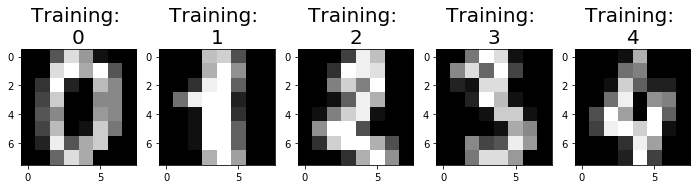

In [4]:
#To Do: Call the function below to display the first five images in our dataset
def examine_images(height=12,width=4):
    plt.figure(figsize=(height,width))
    for index, (image, label) in enumerate(zip(digits.data[0:5], digits.target[0:5])):
        plt.subplot(1, 5, index + 1)
        plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
        plt.title('Training: \n{}'.format(label), fontsize = 20)
        
#Delete this        
examine_images()

## Logistic Regression
Great! Now we are ready to start using a Logistic Regression to make predictions using our images. This pattern should start to feel familiar by now, first we need to import and instantiate our model, then we are going to split our data using the `train_test_split` method, and finally we will fit our model and analyze the score 

In [5]:
from sklearn.linear_model import LogisticRegression

#Instantiate our model
logreg = LogisticRegression(solver='liblinear',multi_class='auto')

#Split our data into testing and training data
x_train, x_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25, random_state=0)

#Fit our model
logreg.fit(x_train, y_train)

#Predict on our entire test dataset. This will return a NumPy array.
predictions = logreg.predict(x_test)
score = logreg.score(x_test, y_test)
print(score)

0.9533333333333334


Well that was easy! As you can see from the score above, we achieved an accuracy score of over .95, so we're all done, right?

Well not quite, as we have discussed in class, .95 is a suspiciously high score. The next thing we should look into is how generalizable our model is, as we seem to be in danger of overfitting our data.

# Cross-Validation
Cross-validation is a statistical method of evaluating generalization performance that is more stable and thorough than simply splitting your data into a training and test set. It is more effective to instead split your data repeatedly, train multiple models, and then examine the scores of those models. Let's try fitting a Logistic Regression model again, but this time we will use k-fold cross-validation

In [6]:
from sklearn.model_selection import KFold, cross_val_score
kfold = KFold(n_splits=6)
scores = cross_val_score(logreg,digits.data,digits.target,cv=kfold)
print('Cross-Validation Scores: {}'.format(scores))
print('Average Cross-Validation Score: {}'.format(scores.mean()))

Cross-Validation Scores: [0.92666667 0.93       0.94666667 0.95986622 0.95652174 0.88963211]
Average Cross-Validation Score: 0.9348922333704942


As you can see in the list of the scores above, the average score of our fitted models is relatively high, but there is quite a bit of variance in our model. This suggests that our model may be too complex and we are experiencing some overfitting.

Another important thing to check for is if the variance in scores is simply due to the order of the labels in our dataset. To ensure that we are not simply seeing worse results because certain splits do not contain an even amount of labels, we can try shuffling our data before we split it by setting the `shuffle` parameter to True.

In [7]:
kfold = KFold(n_splits=6,shuffle=True,random_state=0)
scores = cross_val_score(logreg, digits.data, digits.target, cv=kfold)
print('Shuffled Cross-Validation Scores: {}'.format(scores))
print('Average Shuffled Cross-Validation Score: {}'.format(scores.mean()))

Shuffled Cross-Validation Scores: [0.95       0.94666667 0.97333333 0.95652174 0.97658863 0.95317726]
Average Shuffled Cross-Validation Score: 0.9593812709030102


Perfect! That seemed to work much better, as we eliminated some of the variability in our fitted scores.

# Support Vector Machine
Let's try using another model form to classify our images and see how it compares to our Logistic Regression models.

In [8]:
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, random_state=0)
print('Size of training set: {}\n Size of test set: {}'.format(
    X_train.shape[0], X_test.shape[0]))

Size of training set: 1347
 Size of test set: 450


In [9]:
#Instantiate our model form
svc = SVC(gamma=0.01)

#Fit to our training data
svc.fit(X_train,y_train)

#View the scores of 6 different fitted models using our k-folds from the Logistic Regression
scores = cross_val_score(svc, digits.data, digits.target, cv=kfold)
print('SVM Cross-Validation Scores: {}'.format(scores))
print('Average SVM Cross-Validation Score: {}'.format(scores.mean()))

SVM Cross-Validation Scores: [0.84       0.85       0.76333333 0.88963211 0.73913043 0.78929766]
Average SVM Cross-Validation Score: 0.8118989223337049


## Grid Search

Uh oh... as you can see our model scores are much lower than what we were seeing with Logistic Regression. I suppose we should just give up and declare that the winner, right?

Not so fast! Before we give up on SVM, let's try to adjust the hyper-parameters to see if we can come up with some better scores. The most commonly used method for trying several combinations of hyper-parameters is called `Grid Search` and wouldn't you know it, there are standard methods in scikit-learn to help you with it! Let's try experimenting with two of the main parameters for the SVC class: `gamma` and the regularization parameter (`C`) by using the `GridSearchCV` class, which combines Grid Search with Cross-Validation and implements it in the form of an estimator.

In [10]:
#Defining the parameters that we want to experiment with
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
             'gamma':[0.001, 0.01, 0.1, 1, 10, 100]}
print('Parameter grid:\n{}'.format(param_grid))

Parameter grid:
{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


We can now instantiate the `GridSearchCV` class with our SVC model, the parameter grid to search (`param_grid`), and the cross-validation strategy that we  want to use

In [11]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(SVC(),param_grid,cv=5)

`GridSearchCV` takes care of cross-validation for us, but we still need to split our data into a training and test set to avoid overfitting the parameters

In [12]:
x_train,X_test,y_train,y_test = train_test_split(
    digits.data,digits.target,random_state=0)

The `grid_search` object that we created behaves just like a classifier, which means that we can call the standard methods of `fit`, `predict`, and `score` on it. The difference is that when we call `fit`, it will run cross-validation for each combination of parameters that we listed in `param_grid`.

Please note  that this will likely take a while to run, as we are fitting a model five times for every possible combination of parameters. 

In [13]:
grid_search.fit(X_train, y_train)
print('Best parameters: {}'.format(grid_search.best_params_))
print('Best Cross-Validation Score: {:.2f}'.format(grid_search.best_score_))

Best parameters: {'C': 10, 'gamma': 0.001}
Best Cross-Validation Score: 0.99


Great! It looks like we have found our optimal parameters. The important thing to note here is that we have found the parameters that work best for our training data. Let's take a quick look at a visualization that will summarize how our model performs on our test data.

In [14]:
def visualize_results(cm,score):
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(score)
    plt.title(all_sample_title, size = 15);

def fit_and_evaluate(X, y, model, args):
    model = model(**args)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    avg_score = cross_val_score(model, X_test, y_test, cv=5).mean()
    cm = metrics.confusion_matrix(y_test, predictions)
    visualize_results(cm, avg_score)

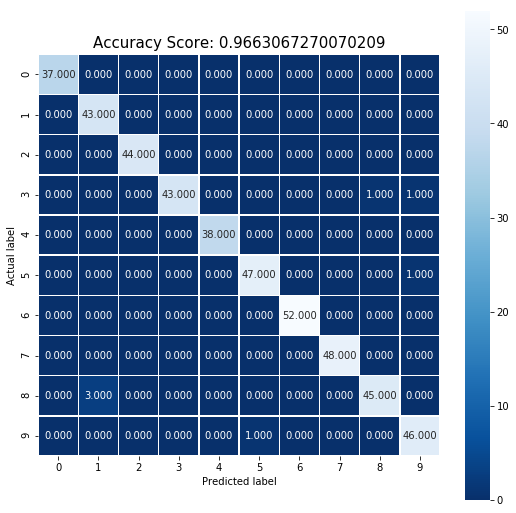

In [15]:
#To do: Fill in the best performing parameters below and call the fit_and_evaluate function to fit and score our model

#Delete this
best_C =10
best_gamma=.0001

best_parameters= {'C':best_C, 'gamma': best_gamma}
#Delete this
fit_and_evaluate(digits.data,digits.target,SVC,best_parameters)

It looks like our model performed pretty well, but is there anything else that we should be concerned about given how high our scores are?

Can you think of any additional models that you would want to try to classify these images?

This notebook was completed with the help of the following resources:

[Introduction to Machine Learning with Python](https://www.oreilly.com/library/view/introduction-to-machine/9781449369880/)

[Logistic Regression using Python (scikit-learn)](https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a)